# Autoencoder

In [27]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from nn import nn
import numpy as np


digits = load_digits()

X = digits.data
y = digits.target

X_train, X_val = train_test_split(X, test_size=0.2, random_state=1729)


In [28]:
# Define the architecture of the autoencoder
nn_arch = [
    {'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
    {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}
]

# Create an instance of the NeuralNetwork class with the defined architecture
autoencoder = nn.NeuralNetwork(nn_arch=nn_arch, lr=0.00001, seed=1729, batch_size=128, epochs=10000, loss_function='mean_squared_error', patience = 1000, progress = 500)


In [29]:
train_loss, val_loss = autoencoder.fit(X_train, X_train, X_val, X_val)

Finished epoch 1 of 10000.
Finished epoch 501 of 10000.
Finished epoch 1001 of 10000.
Finished epoch 1501 of 10000.
Finished epoch 2001 of 10000.
Finished epoch 2501 of 10000.
Early stopping triggered after 2864 epochs.


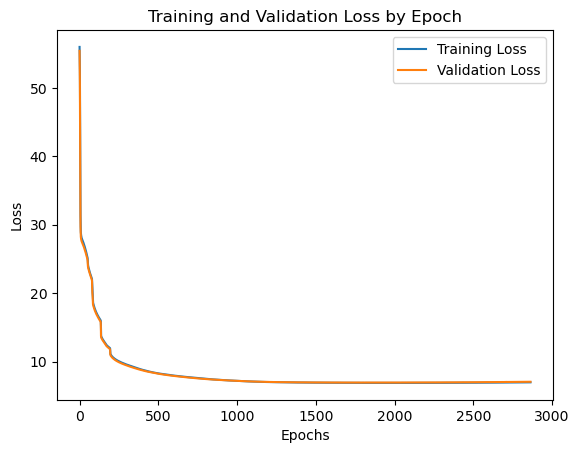

In [30]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss by Epoch')
plt.legend()
plt.show()


In [31]:
# Use the trained autoencoder to reconstruct the validation set
X_val_reconstructed = autoencoder.predict(X_val)

# Calculate the mean squared reconstruction error
reconstruction_error = np.mean(np.square(X_val - X_val_reconstructed))
print(f'Average reconstruction error: {reconstruction_error}')


Average reconstruction error: 6.916492748872463


Text(0.5, 1.0, 'Pred')

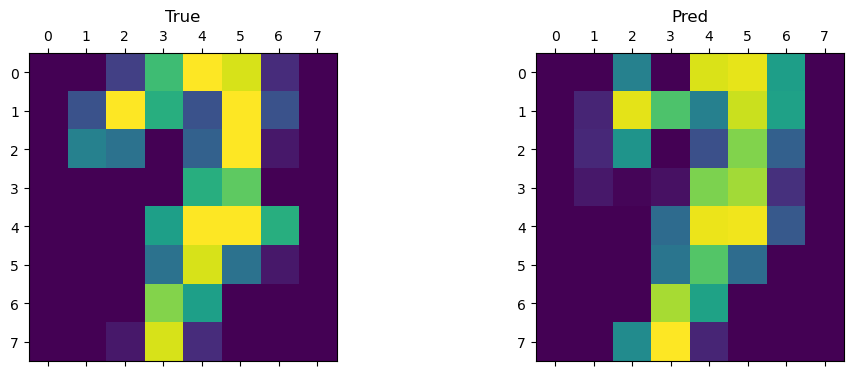

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].matshow(X_val[54].reshape((8, 8)))
ax[0].set_title("True")
ax[1].matshow(X_val_reconstructed[54].reshape((8, 8)))
ax[1].set_title("Pred")

- I chose to have 10000 epoch and an early stopping with 1000 epoch patience, because I want to keep training until it no longer improves performance for 1000 epochs. 
- I tried different learning rate and found that 0.00001 can achieve relatively low loss with a reasonable training time to converge. 
- I chose mean squared error as the loss function because the input and output of autoencoder are one-to-one matched, mean squared error can be used to assess the general loss across the pixels. 

# Classifier

In [9]:
from nn import io
direct = "/Users/zhangyujie/Desktop/BMI 203/final-nn/data/"
positive_seqs = io.read_text_file(direct + 'rap1-lieb-positives.txt')
negative_seqs = io.read_fasta_file(direct + 'yeast-upstream-1k-negative.fa')


In [10]:
window_size = len(positive_seqs[0])
processed_negatives = []

step = 50
for seq in negative_seqs:
    for i in range(0, len(seq) - window_size + 1, step * window_size):
        processed_negatives.append(seq[i:i + window_size])


In [11]:
from nn import preprocess
balanced_seqs, balanced_labels = preprocess.sample_seqs(positive_seqs + processed_negatives, [True] * len(positive_seqs) + [False] * len(processed_negatives))
encoded_seqs = preprocess.one_hot_encode_seqs(balanced_seqs)


- I chose this sampling scheme to effectively address the class imbalance present in the dataset, ensuring that the model has an equal representation of both positive and negative classes for training. By selecting sequences with replacement to match the count of the more prevalent class, the scheme balances the dataset, which can help in preventing the model from being biased towards the majority class. Additionally, for negative sequences longer than the positive ones, slicing them into smaller sequences of the same size as the positive ones (using a defined window size and step) before sampling further aids in creating a balanced dataset. This method allows for a more equitable and diverse training set, promoting better generalization in the model

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(encoded_seqs, balanced_labels, test_size=0.2, random_state=1729)
print("Training data size", X_train.shape[0])
print("Validation data size", X_val.shape[0])

Training data size 10113
Validation data size 2529


In [23]:
nn_arch = [{'input_dim': len(X_train[0]), 'output_dim': 64, 'activation': 'relu'},
           {'input_dim': 64, 'output_dim': 32, 'activation': 'relu'},
           {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
           {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}]

NN = nn.NeuralNetwork(nn_arch=nn_arch, lr=0.02, seed=1729, batch_size=128, epochs=1000, loss_function='binary_cross_entropy', patience = 100, progress = 100)


In [24]:
train_loss, val_loss = NN.fit(X_train, np.array([[i] for i in y_train]), X_val, np.array([[i] for i in y_val]))

Finished epoch 1 of 1000.
Finished epoch 101 of 1000.
Finished epoch 201 of 1000.
Finished epoch 301 of 1000.
Early stopping triggered after 347 epochs.


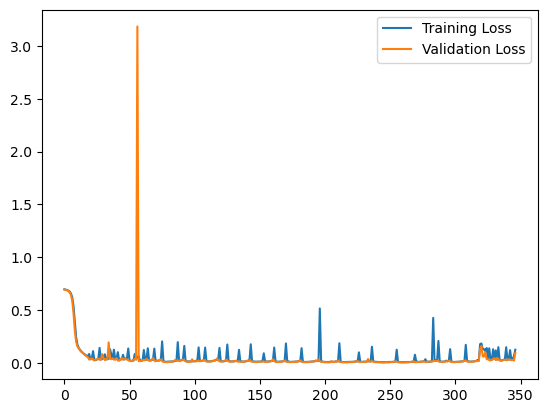

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()


In [26]:
pred = (NN.predict(X_val) >= 0.5).astype(int).T[0]
print(f"Final accuracy on validation set: {np.sum(pred == y_val) / len(y_val)}")

Final accuracy on validation set: 0.9992091735863978


- I chose binary cross entropy as the loss function because the classfier is used to predict a binary class. Binary cross entropy is designed for binary classfiication. 

- I chose to train 1000 epochs with early stopping of 100 epochs, because it's enough for the model to achieve a good accuracy on the validation dataset.

- I tried different learning rate and chose 0.02 as it can achieve relatively low loss with a reasonable training time to converge. 